In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('..')+'/src')
if module_path not in sys.path:
    sys.path.append(module_path)

# Ansatz

In this file, we illustrate the use of the Class ansatz.

In [2]:
import torch
from torch import nn
import warnings
import matplotlib.pyplot as plt

import warnings
import torch
import torch as tc
from torch.func import jacfwd, vmap, grad,jacrev

from models.ansatz import Ansatz

Use of the Ansatz

> Example of utilisation for the Class Anstatz
epoch: 0 | loss:  tensor(24.8018, grad_fn=<MseLossBackward0>)
epoch: 3000 | loss:  tensor(24.8018, grad_fn=<MseLossBackward0>)
 - Training is complete


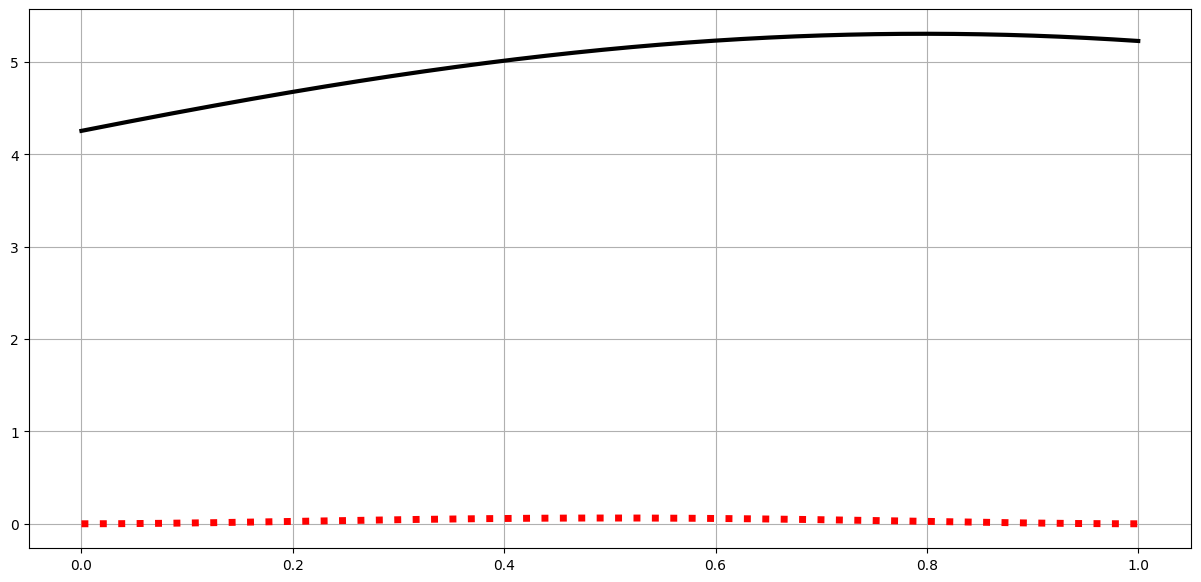

In [3]:
print("> Example of utilisation for the Class Anstatz")
    
# Definition of the space domain and the fonction to approximate
x_domain = [0.0, 1.0]; n_points_x = 1000
mesh_x = torch.linspace(x_domain[0], x_domain[1], steps=n_points_x, requires_grad=True).unsqueeze(1)
u0 = lambda x : (1-x)**2 * x**2
y_true = u0(mesh_x).squeeze()
   
# Definition of the model
d = 1
m = 10
model = Ansatz(d,m)
    
    # Training
criterion=torch.nn.MSELoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-3)

total_acc, total_loss=[], []
for epoch in range(6000):
    y_pred=model(mesh_x)
    loss = criterion(y_pred,y_true)
    if epoch%3000 == 0:
        print('epoch:',epoch,'| loss: ', loss)
    optimizer.zero_grad()
    loss.backward(retain_graph=True) # back propagation
    optimizer.step()
print(' - Training is complete')
    
    # Visualisation
y_train = model(mesh_x)
fig = plt.figure(figsize=(15, 7))
plt.plot(mesh_x.detach(), y_train.detach(), 'k', lw=3)
plt.plot(mesh_x.detach(), y_true.detach(),'r:', lw=5)
plt.grid()
plt.show()


In [5]:
torch.manual_seed(42)
theta = tc.rand(3*m,requires_grad=True)
theta1 = tc.rand(3*m,requires_grad=True)
A = Ansatz(d,m)
mesh_x = tc.linspace(0,1,10)
a = out(theta,mesh_x)
def test(theta, x):
    model = Ansatz(d,m,theta)(x)
    return model

a2 = jacrev(test,argnums=0)(theta,mesh_x)
a,a2

(tensor([ 9.7930e+00,  9.7890e+00,  9.7945e+00,  9.3119e+00,  9.9823e+00,
          9.9230e+00,  9.6882e+00,  9.9575e+00,  9.5554e+00,  1.0000e+01,
         -5.3794e-01, -3.1380e-01, -2.3990e-01, -7.2525e-01, -2.0797e-02,
          6.0244e-02, -2.4030e-01, -4.6052e-02,  1.1817e+00, -1.2884e-05,
         -1.3260e+00, -8.5683e-01, -5.1831e-01, -1.4826e+00, -1.3104e-01,
         -3.4101e-01, -4.3117e-01, -3.3686e-01, -1.4514e+00, -1.9379e-03],
        grad_fn=<ViewBackward0>),
 tensor([[ 9.3847e-01,  9.3367e-01,  9.3553e-01,  8.0017e-01,  9.9393e-01,
           9.8670e-01,  9.0399e-01,  9.8699e-01,  9.7895e-01,  9.9999e-01,
          -1.1252e-01, -1.9757e-01, -5.4908e-02, -6.0286e-01, -6.3797e-03,
          -3.6981e-02, -5.2881e-02, -3.5736e-02, -1.4702e-01, -6.3428e-06,
          -3.9001e-01, -2.6570e-01, -1.6077e-01, -4.1152e-01, -4.4894e-02,
          -5.8925e-02, -1.3049e-01, -1.0287e-01, -7.1626e-02, -6.4603e-04],
         [ 9.5189e-01,  9.5567e-01,  9.5057e-01,  8.6571e-01,  9.9561e